In [1]:
import torch.nn as nn
import numpy as np
import requests
import logging
import base64
import random
import torch
import glob
import json
import cv2
import os
import sys

from io import BytesIO
from PIL import Image

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.projects.point_rend import ColorAugSSDTransform, add_pointrend_config
from torchvision import transforms
import torchvision.models as models
import copy
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

def read_json(path):
    if os.path.isfile(path):
        with open(path) as f:
            data = json.load(f)
        return data
    else:
        return None
    

In [2]:
class EmbeddingModel(nn.Module):
    def __init__(self, backbone: nn.Module,last_layer = 512, emb_dim=128):
        super().__init__()
        self.backbone = backbone
        self.embeddings = nn.Linear(last_layer, emb_dim)
        self.softmax = nn.Softmax()

    def forward(self, x: torch.Tensor):
        return self.embeddings(self.backbone(x))
    
class EmbeddingClassifier:
    def __init__(self, model_path, data_set_path, device='cpu'):
        self.device = device
        self.model_path = model_path
        
        resnet18 = models.resnet18()
        resnet18.fc = nn.Identity()

        self.model = EmbeddingModel(resnet18, 512, 256)
        self.model.load_state_dict(torch.load(self.model_path, map_location=torch.device(device)))
        self.model.eval()
        self.model.to(device)
        
        self.loader = transforms.Compose([
            transforms.Resize((224, 224), Image.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.data_base = torch.load(data_set_path).to(device)
        
    def __inference(self, image, top_k=10):
        dump_embed = self.model(image.unsqueeze(0).to(self.device)).detach()
        
        topest = self.__classify(dump_embed[0])
        my_dict = sorted(topest, key=lambda x: x[1], reverse=False)
        my_dict = self.__remove_duplicate(my_dict[:20])
        return my_dict

    
    def inference_numpy(self, img, top_k=10):
        image = Image.fromarray(img)
        image = self.loader(image).float()
        image = torch.tensor(image)
        return self.__inference(image, top_k)
    
    def __classify(self, embedding):
        diff = (self.data_base - embedding).pow(2).sum(dim=2).sqrt()
        val, indi = torch.sort(diff)
        class_lib = []
        for idx, i in enumerate(val):
            for dist_id, dist in enumerate(i[:10]):
                class_lib.append([idx, dist])
        return class_lib
    
    
    @staticmethod
    def __remove_duplicate(mylist):
        seen = set()
        newlist = []
        for item in mylist:
            t = tuple(item)
            if t[0] not in seen:
                newlist.append(item)
                seen.add(t[0])
        return newlist

In [3]:
class SegmentationInference:
    def __init__(self, model_path, config, device):
        self.model_path = model_path
        
        self.cfg = get_cfg()
        add_pointrend_config(self.cfg)
        self.cfg.merge_from_file(config)
        self.cfg.DATALOADER.NUM_WORKERS = 2
        self.cfg.MODEL.POINT_HEAD.NUM_CLASSES = 1
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
        
        self.cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65
        self.cfg.MODEL.DEVICE = device
        self.cfg.MODEL.WEIGHTS = self.model_path
        self.cfg.freeze()
        self.model = DefaultPredictor(self.cfg)

    def inference(self, img):
        outputs = self.model(img)
        return outputs

# Define segmentation and classification model file paths

In [4]:
path_to_segmentation_model = r'model_1799999.pth'
path_to_segmentation_config = r'/home/fishial/Fishial/detectron2/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml'


path_to_classification_model = r'model_184.ckpt'
path_to_classification_embeddings = r'embeddings.pt'
path_to_labels_file = r'labels.json'


In [5]:
model_segmentation = SegmentationInference(
        path_to_segmentation_model,
        config = path_to_segmentation_config,
        device = 'cpu')

In [6]:
model_classifier = EmbeddingClassifier(
    path_to_classification_model,
    path_to_classification_embeddings,
    device='cpu')
labels = read_json(path_to_labels_file)

/home/fishial/miniconda3/envs/detectron2_env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


# Define the path to the image and run the block

### the lower the number, the more likely it is the selected class


/home/fishial/miniconda3/envs/detectron2_env/lib/python3.6/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/fishial/miniconda3/envs/detectron2_env/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811805959/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/fishial/miniconda3/envs/detectron2_env/lib/python3.6/sit

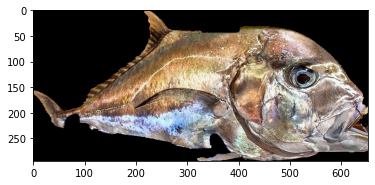

[['Alectis ciliaris', 2.83331036567688], ['Thunnus albacares', 8.174520492553711], ['Coryphaena hippurus', 8.631998062133789], ['Thunnus atlanticus', 8.812531471252441], ['Makaira nigricans', 8.891765594482422], ['Scomberomorus cavalla', 8.894552230834961], ['Sphyraena barracuda', 8.955659866333008]]


/home/fishial/miniconda3/envs/detectron2_env/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [7]:
image_path = '/home/fishial/Fishial/dataset/classification/fo_data/data/0dfb19c5-97a8-56c4-9499-7b6f0d58ca44.png'
im = cv2.imread(image_path)


outputs = model_segmentation.inference(im)

for mask_id in range(len(outputs['instances'].pred_boxes.tensor)):
    x_1, y_1, x_2, y_2 = outputs['instances'].pred_boxes.tensor[mask_id].numpy()
    mask = outputs['instances'].pred_masks[0].numpy()
    mask = mask[int(y_1):int(y_2), int(x_1):int(x_2)].copy()
    img = im[int(y_1):int(y_2), int(x_1):int(x_2)].copy()
    img[mask==0] = (0,0,0)
    plt.imshow(img)
    plt.show()
    output = model_classifier.inference_numpy(img)
    output = [[labels[str(result[0])], result[1].item()] for result in output]
    output = print(output)